In [1]:
import torch
import numpy as np

## Etude 1
Let $u$ be a vector of $2D$ points. We need to get a matrix $A$ whose element $(i,j)$ depends on euclidean distance between $u_i$ and $u_j$.

$$u \in \mathbb{R}^{N \times 2}$$
$$A \in \mathbb{R}^{N \times N}, \ A_{ij} = f(\|u_i - u_j\|) $$

Particularly, let's take $f(x) = exp(-\frac{x}{4})$.

### Naive approach

In [2]:
def naive(u, N):
    result = torch.zeros(N, N)
    for i in range(N):
        for j in range(N):
            result[i,j] = torch.exp(-0.25 * torch.dist(u[i], u[j]))
    return result

### Vectorized approaches

In [3]:
def fully_vectorized(u, N):
    u_ = u.reshape(1, *u.shape) # add one dimension for transposing
    A_ = u_.permute((1, 0, 2)) - u_ # row - column: broadcasting subtraction
    return A_.pow_(2).sum(dim=2).sqrt_().mul_(-0.25).exp_()

In [4]:
def one_dim_vectorized(u, N):
    result = torch.zeros(N, N)
    for i in range(N):
        du = u[i] - u
        result[i,:] = du.pow_(2).sum(dim=1).sqrt_().mul_(-0.25).exp_()
    return result

### Comparison

#### fully vectorized vs. naive

In [5]:
N = 10**3
u = torch.randn(N, 2)

In [6]:
%%time
A = naive(u, N)

CPU times: user 12.6 s, sys: 452 ms, total: 13.1 s
Wall time: 13.1 s


In [7]:
%%time
B = fully_vectorized(u, N)

CPU times: user 72 ms, sys: 4 ms, total: 76 ms
Wall time: 37.2 ms


In [8]:
assert torch.equal(A, B)

#### 1-dim vectorized vs. fully vectorized

In [9]:
N = 10**4
u = torch.randn(N, 2)

In [10]:
%%timeit
A = fully_vectorized(u, N)

2.51 s ± 325 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%%timeit
B = one_dim_vectorized(u, N)

2.74 s ± 263 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
assert torch.equal(A, B)

### t(N)

In [13]:
import time
import matplotlib.pyplot as plt
%matplotlib inline

def bench(func, n_range, repeat=3):
    t = []
    for n in n_range:
        t0 = []
        for i in range(repeat):
            u = torch.randn(n, 2)
            start = time.time()
            func(u, n)
            end = time.time()
            t0.append(end-start)
        t.append(sum(t0)/len(t0))
    return t

In [14]:
n = list(range(10**3, 6*10**3, 10**3))
t_fv = bench(func=fully_vectorized, n_range=n)
t_1dv = bench(func=one_dim_vectorized, n_range=n)

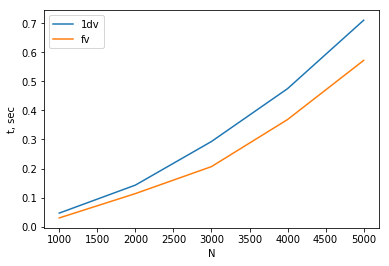

In [15]:
plt.plot(n, t_1dv, label='1dv')
plt.plot(n, t_fv, label='fv')
plt.ylabel('t, sec')
plt.xlabel('N')
plt.legend()
plt.savefig("1d_vs_fully")